In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import yfinance as yf
from pandas_datareader import data as pdr
import openpyxl  
import xlrd
#import xlwt
import xlsxwriter    
from flask import Flask, render_template, request
import bs4
#import PySide2
#import ipykernel
import IPython
#import ipywidgets
#import ipython_beautifulsoup  
import jupyter

import librairie

yf.pdr_override()
import datetime

In [2]:
def calculate_mean(symbol):
    data = yf.download(symbol)
    mean = data[data.columns[3]].values.tolist().mean()
    return mean

In [3]:
app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        symbol = request.form['symbol']
        mean = calculate_mean(symbol)
        return render_template('result.html', symbol=symbol, mean=mean)
    return render_template('form.html')


In [4]:
def calculate_typical_price(data):
    high_prices = data['High'].values.tolist()
    low_prices = data['Low'].values.tolist()
    close_prices = data['Close'].values.tolist()
    typical_prices = [(high + low + close) / 3 for high, low, close in zip(high_prices, low_prices, close_prices)]
    return typical_prices


def calculate_raw_money_flow(data):
    high_prices = data[data.columns[1]].values.tolist()
    low_prices = data[data.columns[2]].values.tolist()
    close_prices = data[data.columns[3]].values.tolist()
    typical_price = calculate_typical_price(data)
    return np.array(typical_price) * np.array(data[data.columns[5]].values.tolist())


def money_flow_index(data, period):
    typical_price = pd.Series(calculate_typical_price(data))
    raw_money_flow = calculate_raw_money_flow(data)
    positive_money_flow = np.where(typical_price > typical_price.shift(1), raw_money_flow, 0)
    negative_money_flow = np.where(typical_price < typical_price.shift(1), raw_money_flow, 0)
    positive_money_flow_sum = pd.Series(positive_money_flow).rolling(window=period).sum()
    negative_money_flow_sum = pd.Series(negative_money_flow).rolling(window=period).sum()
    mfi = 100 - (100 / (1 + (positive_money_flow_sum / negative_money_flow_sum)))
    return mfi

def relative_strength_index(data, period):
    df = pd.DataFrame(data)

    close_series = pd.Series(df[df.columns[3]].astype(float))
    close_diff = close_series.diff()

    gain = np.where(close_diff >= 0, close_diff, 0)
    loss = np.where(close_diff < 0, abs(close_diff), 0)

    average_gain = pd.Series(gain).rolling(window=period).mean()
    average_loss = pd.Series(loss).rolling(window=period).mean()

    relative_strength = average_gain / average_loss
    rsi = 100 - (100 / (1 + relative_strength))

    return rsi.tolist()

def moving_average_convergence_divergence(data, short_period, long_period, signal_period):
    df = pd.DataFrame(data)

    close_series = pd.Series(df[df.columns[3]].astype(float))
    exp_short = close_series.ewm(span=short_period, adjust=False).mean()
    exp_long = close_series.ewm(span=long_period, adjust=False).mean()
    macd_line = exp_short - exp_long
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line

    return macd_line.tolist(), signal_line.tolist(), histogram.tolist()

In [5]:
# Les données de The Boeing Company (BA) du 1er janvier 2021 à aujourd'hui

depart=datetime.datetime(2021,1,1)  # 1er janvier 2021
fin=datetime.datetime.today()  # jour=aujourd'hui
period = (fin - depart).days  # Période basée sur le temps écoulé en jours

data_BA=pdr.get_data_yahoo('BA', 
               start=depart,
               end=fin)

[*********************100%***********************]  1 of 1 completed


In [6]:
# Vérification des valeurs manquantes dans les données
missing_values = data_BA.isnull().sum()
print(missing_values)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
#money_flow_index(data_BA, 5)
#relative_strength_index(data_BA,5)

# Exemple d'utilisation
data = data_BA  # Remplacez [...] par votre liste de données réelle
short_period = 12  # Remplacez 12 par la période souhaitée pour la moyenne mobile exponentielle courte
long_period = 26  # Remplacez 26 par la période souhaitée pour la moyenne mobile exponentielle longue
signal_period = 9  # Remplacez 9 par la période souhaitée pour la ligne de signal

macd, signal, histogram = moving_average_convergence_divergence(data, short_period, long_period, signal_period)
print("MACD Line:", macd)
print("Signal Line:", signal)
print("Histogram:", histogram)

MACD Line: [0.0, 0.7107695229032913, 1.2116765593943342, 1.7243345393528386, 1.882178549166099, 1.73630496344569, 1.7314611873786134, 1.6122082024249096, 1.715788005498439, 1.3314614994081353, 1.5249211795724875, 1.7181446949269343, 1.527671976781761, 1.2357890979350827, 0.7951884470927268, 0.3372225832202389, -0.6659952763755541, -1.189132073334406, -1.8279523094656156, -2.1759976843849245, -2.017047019048249, -1.3549970600894028, -0.5615961285964204, -0.1497686280645496, 0.49527911207056263, 1.247891536057267, 1.5680537466024305, 1.7005111446710828, 1.8104356965862394, 2.3705138263329673, 2.649886347934256, 2.2769736949165917, 2.676008679101983, 2.5919935465482524, 2.4360037771010354, 3.65970415451784, 3.5484756766300904, 3.066704159578734, 3.641878384340316, 3.951295473434527, 4.581051787786805, 4.715123114406111, 4.647570318263945, 4.606295763929069, 5.046365182082155, 6.5086828733495565, 8.111482691424214, 10.646081231493184, 12.226566536200778, 12.494279481839868, 13.230130341087

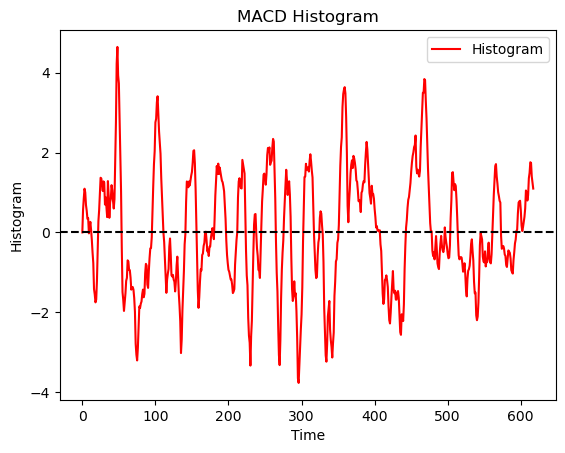

In [8]:
# Tracer l'histogramme
plt.plot(histogram, color='red', label='Histogram')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Histogram')
plt.title('MACD Histogram')
plt.legend()
plt.show()

In [9]:
size_of_data = data_BA.shape[0]  # Obtient le nombre de lignes dans les données
if period <= size_of_data:
    # Effectuer le calcul de l'indicateur MFI avec la période spécifiée
    mfi_result = money_flow_index(data_BA, period)
else:
    # Gérer le cas où la période est supérieure à la taille des données
    print("La période spécifiée est supérieure à la taille des données.")


La période spécifiée est supérieure à la taille des données.


In [10]:
nb_observations = len(data_BA)
print("Nombre d'observations :", nombre_observations)

# Calculer la valeur minimale des observations
valeur_minimale = data_BA['Close'].min()
print("Valeur minimale des observations :", valeur_minimale)

# Calculer la valeur maximale des observations
valeur_maximale = data_BA['Close'].max()
print("Valeur maximale des observations :", valeur_maximale)

# Calculer la moyenne empirique des observations
moyenne = data_BA['Close'].mean()
print("Moyenne empirique des observations :", moyenne)

# Calculer la variance empirique des observations
variance = data_BA['Close'].var()
print("Variance empirique des observations :", variance)

#Calculer l'asymétrie (skewness) empirique des observations
asymetrie = data_BA['Close'].skew()
print("Asymétrie (skewness) empirique des observations :", asymetrie)

#Calculer l'aplatissement (kurtosis) empirique des observations
aplatissement = data_BA['Close'].kurtosis()
print("Aplatissement (kurtosis) empirique des observations :", aplatissement)

Nombre d'observations : 618
Valeur minimale des observations : 115.86000061035156
Valeur maximale des observations : 269.19000244140625
Moyenne empirique des observations : 197.6890939138468
Variance empirique des observations : 1148.2317263642192
Asymétrie (skewness) empirique des observations : -0.5577066070022492
Aplatissement (kurtosis) empirique des observations : -0.442668145140519


In [11]:
# Créer un objet ArgumentParser
parser = argparse.ArgumentParser()

# Ajouter un argument pour le nombre d'observations
parser.add_argument('--nombre_observations', type=int, help='Nombre d\'observations')

# Analyser les arguments de la ligne de commande
args = parser.parse_args()

# Récupérer la valeur du nombre d'observations
nombre_observations = args.nombre_observations

# Afficher le nombre d'observations
print("Nombre d'observations :", nombre_observations)

usage: ipykernel_launcher.py [-h] [--nombre_observations NOMBRE_OBSERVATIONS]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"962432f8-fd18-4753-825f-e9337f834176" --shell=9002 --transport="tcp" --iopub=9004 --f=/Users/linaelhaddaj/Library/Jupyter/runtime/kernel-v2-15041uqyQ8YkT04TP.json


SystemExit: 2

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
